# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

## 2.1 Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds.lwe_thickness
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [5]:
'''
Full catalog - Convert earthquake data to a GeoDataFrame
'''
# Convert lon and lat to Shapely Point objects
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]

# GeoDataFrame for the full earthquake catalog
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  
# EPSG:4326 specifies the coordinate reference system (WGS 84)
catalog_gdf_full.sindex

'''
ETAS Declustered Catalog - Convert ETAS declustered earthquake data to a GeoDataFrame
'''
# Convert ETAS catalog's coordinates into Shapely Point objects
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]

# GeoDataFrame for the ETAS declustered catalog
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")
catalog_gdf_etas.sindex

In [6]:
def calc_cp_by_mascon_lag(catalog_gdf, loads, taus):
    """
    Calculates conditional probability P(E|L_tau) in every mascon using each mascon's center coordinates 
    and creating a 1.5-degree radius spherical cap around each one.
    
    Parameters:
    -----------
    catalog_gdf: Earthquake catalog with 'time' (datetime64) and 'dmass' columns.
    loads:       GRACE-derived surface load dataset with 'time', 'lat', 'lon' dimensions.
    taus:        Lags (in months) to test. Default = np.arange(1, 13).
    
    Returns:
    --------
    cp_tau_mean: Mean conditional probabilities across mascons for each lag.
    bins:        Bin edges for load values.
    taus:        Array of tau values in months.
    """

    grace_times = loads.time.values.astype("datetime64[M]")  # monthly timestamps
    cp_all_mascons = []  # list of (n_tau, n_bins) arrays for each mascon

    for i in range(len(mascon_id)):
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])
        bbox = center_point.buffer(cap_radius_deg)
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Find earthquakes inside this mascon
        these_eq = gpd.sjoin(catalog_gdf, bbox_gdf, how="inner", predicate="within")
        if these_eq.empty:
            continue

        # Extract loads for this mascon
        L = loads.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # For each earthquake, find nearest GRACE time index
        eq_times = these_eq["time"].values.astype("datetime64[M]")
        t_indices = np.array([np.argmin(np.abs(grace_times - t)) for t in eq_times])

        cp_by_tau = []

        for tau in taus:
            # Shift earthquake indices by lag tau
            lag_indices = t_indices - tau
            valid_mask = (lag_indices >= 0)

            if not np.any(valid_mask):
                cp_by_tau.append(np.full_like(np.histogram(L, bins=np.linspace(-80, 80, 80))[0], np.nan, dtype=float))
                continue

            # Get lagged loads corresponding to valid earthquakes
            LgE_tau = L[lag_indices[valid_mask]]

            # Compute conditional probability for this tau
            bins = np.linspace(-80, 80, 80)
            LgE_hist = np.histogram(LgE_tau, bins=bins, density=True)[0]
            L_hist = np.histogram(L, bins=bins, density=True)[0]
            cp_tau = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)
    
            # Weight by number of earthquakes
            E = np.sum(valid_mask)
            cp_by_tau.append(cp_tau * E)

        cp_all_mascons.append(np.vstack(cp_by_tau))  # shape (n_tau, n_bins)

    cp_all_mascons = np.array(cp_all_mascons)  # shape (n_mascon, n_tau, n_bins)
    # cp_tau_mean = np.nanmean(cp_all_mascons, axis=0)  # average cp (given a tau lag) across all mascons

    return cp_all_mascons, bins, taus

In [7]:
cp_all, bins, taus = calc_cp_by_mascon_lag(catalog_gdf_full, lwe_data, np.arange(1, 13))

## 2.2 Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [8]:
etas_cp_all, etas_bins, etas_taus = calc_cp_by_mascon_lag(catalog_gdf_etas, lwe_data, np.arange(1, 13))

## 2.3 Visualizing correlation for full & declustered catalog

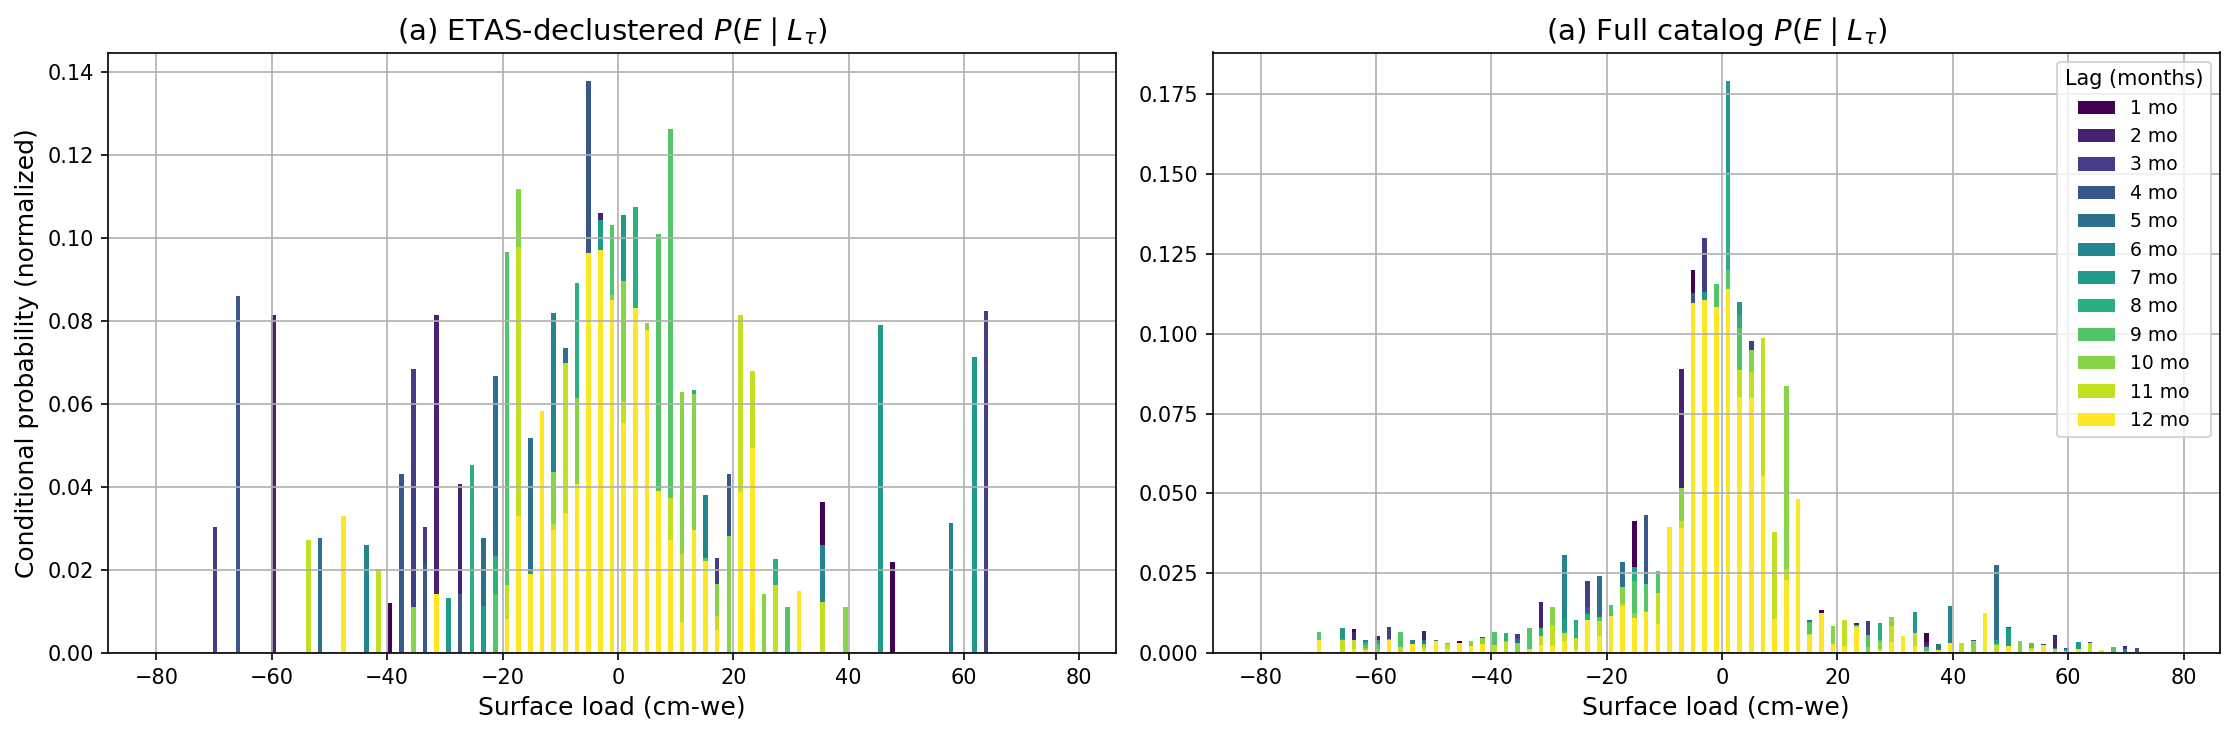

In [155]:
# Average across mascons to get average cp (given lag tau) over all mascons 
cp_tau_mean = np.nanmean(cp_all, axis=0)          # shape (n_tau, n_bins)
etas_cp_tau_mean = np.nanmean(etas_cp_all, axis=0)

# Normalize each by its sum for comparability
cp_tau_norm = cp_tau_mean / np.nansum(cp_tau_mean, axis=1)[:, None]
etas_cp_tau_norm = etas_cp_tau_mean / np.nansum(etas_cp_tau_mean, axis=1)[:, None]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
fs = 12
colors = plt.cm.viridis(np.linspace(0, 1, len(taus)))

# (a) ETAS-declustered
for i, tau in enumerate(etas_taus):
    axes[0].bar(etas_bins[:-1], etas_cp_tau_norm[i], color=colors[i], label=f'{tau} mo')

axes[0].set_title(r'(a) ETAS-declustered $P(E\mid L_{\tau})$', fontsize=fs+2)
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability (normalized)', fontsize=fs)
axes[0].grid(True)

# (b) Full catalog
for i, tau in enumerate(taus):
    axes[1].bar(bins[:-1], cp_tau_norm[i], color=colors[i], label=f'{tau} mo')

axes[1].set_title(r'(a) Full catalog $P(E \mid L_{\tau})$', fontsize=fs+2)
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
# axes[1].set_ylabel('Conditional probability (normalized)', fontsize=fs)
axes[1].grid(True)
axes[1].legend(title='Lag (months)', fontsize=9)

plt.tight_layout()
plt.show()


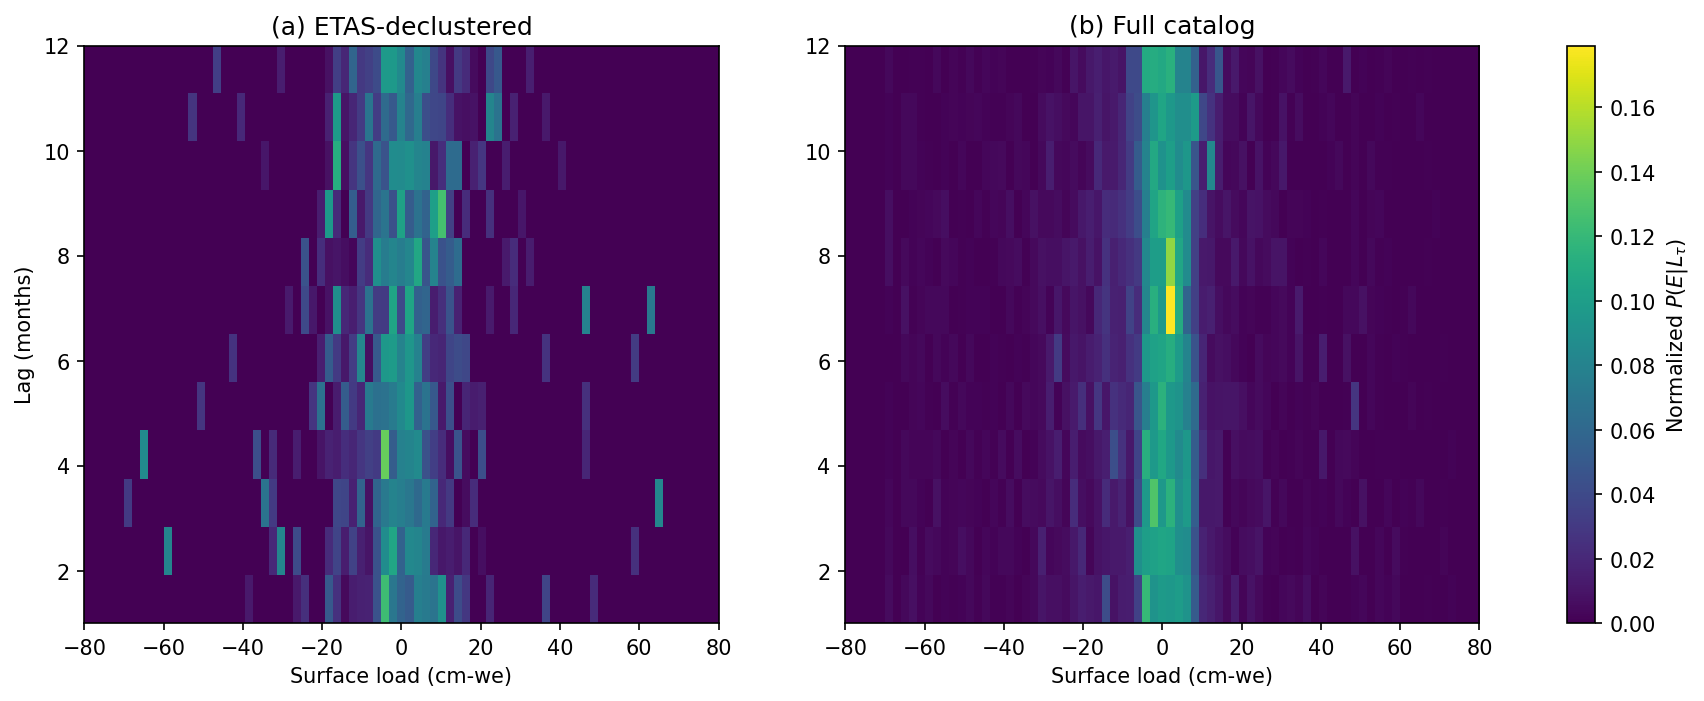

In [156]:
vmin = min(np.nanmin(etas_cp_tau_norm), np.nanmin(cp_tau_norm))
vmax = max(np.nanmax(etas_cp_tau_norm), np.nanmax(cp_tau_norm))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# (a) ETAS-declustered 
im1 = axes[0].imshow(
    etas_cp_tau_norm,
    aspect='auto',
    origin='lower',
    extent=[etas_bins[0], etas_bins[-1], etas_taus[0], etas_taus[-1]],
    cmap='viridis',
    vmin=vmin, vmax=vmax
)
axes[0].set_title('(a) ETAS-declustered', fontsize=12)
axes[0].set_xlabel('Surface load (cm-we)')
axes[0].set_ylabel('Lag (months)')

# (b) Full catalog 
im2 = axes[1].imshow(
    cp_tau_norm,
    aspect='auto',
    origin='lower',
    extent=[bins[0], bins[-1], taus[0], taus[-1]],
    cmap='viridis',
    vmin=vmin, vmax=vmax
)
axes[1].set_title('(b) Full catalog', fontsize=12)
axes[1].set_xlabel('Surface load (cm-we)')

cbar = fig.colorbar(im2, ax=axes, orientation='vertical')
cbar.set_label('Normalized $P(E|L_{\\tau})$', fontsize=10)

plt.show()


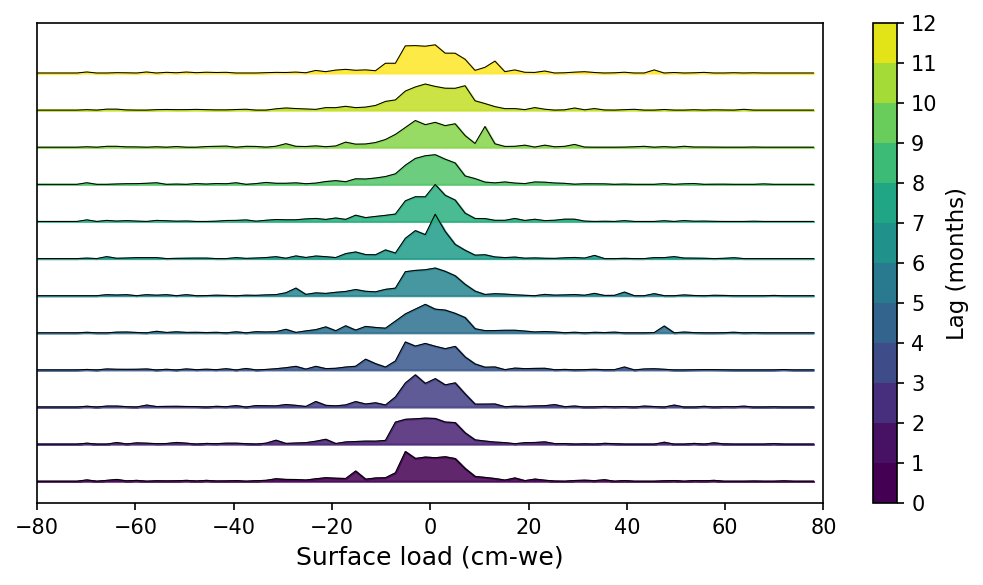

In [152]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

offset = 0
spacing = 0.15
colors = plt.cm.viridis(np.linspace(0, 1, len(taus)))

for i, tau in enumerate(taus):
    y = cp_tau_norm[i]
    ax.fill_between(bins[:-1], offset, y + offset, color=colors[i], alpha=0.85)
    ax.plot(bins[:-1], y + offset, color='k', lw=0.5)
    offset += spacing

ax.set_xlabel('Surface load (cm-we)', fontsize=12)
# ax.set_ylabel('Lag (stacked)', fontsize=12)
ax.set_xlim(bins[0], bins[-1])
ax.set_yticks([])

# --- Add colorbar legend for τ ---
norm = mpl.colors.Normalize(vmin=min(taus), vmax=max(taus))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
bounds = np.linspace(0, 12, 13)
cbar = plt.colorbar(sm, ax=ax, pad=0.05, ticks=bounds,boundaries=bounds)
cbar.set_label('Lag (months)', fontsize=11)

plt.tight_layout()
plt.show()
